In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('stripe82_galaxies.csv')
df.head()

,z,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z
0,0.487877,22.477301,20.988800,20.424500,20.143900
1,0.542116,22.528000,20.726801,19.908001,19.562599
2,0.088652,17.335899,16.480900,16.117300,15.835100
3,0.079106,18.039499,17.372999,17.069401,16.846300
4,0.129128,19.151699,18.665701,18.446100,18.326900


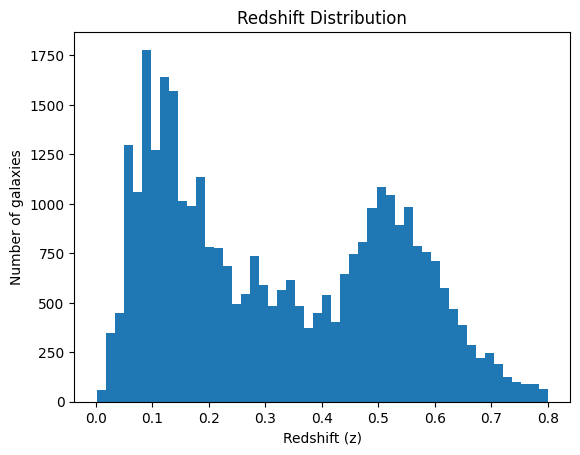

In [4]:
# Plot histogram of redshift
plt.hist(df['z'], bins=50)
plt.xlabel('Redshift (z)')
plt.ylabel('Number of galaxies')
plt.title('Redshift Distribution')
plt.show()

##### Data Preparation

In [5]:
X = df.drop(columns=['z']).values
y = df['z'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Standarise the data
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [7]:
# Convert Array to Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Training CGAN Model

In [8]:
# Hyperparameters
g_dim = 32
d_dim = 32
z_dim = 20
lr = 1e-4
step = 2000
gamma = 0.2
epochs = 10000

##### Generator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + 4, g_dim),
            nn.BatchNorm1d(g_dim),
            nn.ReLU(),
            nn.Linear(g_dim, g_dim),
            nn.BatchNorm1d(g_dim),
            nn.ReLU(),
            nn.Linear(g_dim, 1),
        )

    def forward(self, x, z):
        out = torch.cat([x, z], dim=1)
        return self.net(out)

##### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4 + 1, d_dim),
            nn.BatchNorm1d(d_dim),
            nn.ReLU(),
            nn.Linear(d_dim, d_dim),
            nn.BatchNorm1d(d_dim),
            nn.ReLU(),
            nn.Linear(d_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        out = torch.cat([x, y], dim=1)
        return self.net(out)

In [11]:
generator  = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.MSELoss()

optimG = torch.optim.Adam(generator.parameters(), lr=lr)
optimD = torch.optim.Adam(discriminator.parameters(), lr=lr)

schedulerG = torch.optim.lr_scheduler.StepLR(optimG, step_size=step, gamma=gamma)
schedulerD = torch.optim.lr_scheduler.StepLR(optimD, step_size=step, gamma=gamma)

##### Training loop

In [12]:
# losses
g_losses = []
d_losses = []
g_test_losses = []
d_test_losses = []
mse = []
mse_test = []

In [13]:
for epoch in range(epochs):
    generator.train(), discriminator.train()
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Train discriminator
    optimD.zero_grad()
    z = torch.randn(X_train.size(0), z_dim, device=device)
    y_train_fake = generator(X_train, z)
    d_real = discriminator(X_train, y_train)
    d_fake = discriminator(X_train, y_train_fake)
    loss_d = -torch.log(d_real).mean() - torch.log(1 - d_fake).mean()
    loss_d.backward()
    optimD.step()

    # Train generator
    optimG.zero_grad()
    z = torch.randn(X_train.size(0), z_dim, device=device)
    y_train_fake = generator(X_train, z)
    d_fake = discriminator(X_train, y_train_fake)
    loss_g = -torch.log(d_fake).mean()
    epoch_mse = criterion(y_train_fake, y_train)
    loss_g.backward()
    optimG.step()

    g_losses.append(loss_g.item())
    d_losses.append(loss_d.item())
    mse.append(epoch_mse.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch : {epoch+1}/{epochs}, loss_d = {loss_d:4f}, loss_g = {loss_g:4f}")

    schedulerG.step()
    schedulerD.step()

    # Model evaluation on test set
    generator.eval()
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
        z = torch.randn(X_test.size(0), z_dim, device=device)
        y_test_fake = generator(X_test, z)
        d_real = discriminator(X_test, y_test)
        d_fake = discriminator(X_test, y_test_fake)
        loss_d = -torch.log(d_real).mean() - torch.log(1 - d_fake).mean()
        loss_g = -torch.log(d_fake).mean()
        epoch_mse_test = criterion(y_test_fake, y_test)

        g_test_losses.append(loss_g.item())
        d_test_losses.append(loss_d.item())
        mse_test.append(epoch_mse_test.item())


# Save Model
torch.save(generator.state_dict(), "CGAN_model.pth")

losses_cgan_df = pd.DataFrame(
    {
        "g_losses": g_losses,
        "d_losses": d_losses,
        "g_test_loss": g_test_losses,
        "d_test_loss": d_test_losses,
        "mse": mse,
        "mse_test": mse_test,
    })
losses_cgan_df.to_csv("CGAN_losses.csv", index=False)

Epoch : 500/10000, loss_d = 1.336316, loss_g = 0.729008
Epoch : 1000/10000, loss_d = 1.360959, loss_g = 0.712811
Epoch : 1500/10000, loss_d = 1.342750, loss_g = 0.726523
Epoch : 2000/10000, loss_d = 1.358022, loss_g = 0.723202
Epoch : 2500/10000, loss_d = 1.355705, loss_g = 0.718912
Epoch : 3000/10000, loss_d = 1.353762, loss_g = 0.721967
Epoch : 3500/10000, loss_d = 1.351142, loss_g = 0.727689
Epoch : 4000/10000, loss_d = 1.347011, loss_g = 0.721875
Epoch : 4500/10000, loss_d = 1.348004, loss_g = 0.725838
Epoch : 5000/10000, loss_d = 1.348479, loss_g = 0.725103
Epoch : 5500/10000, loss_d = 1.346352, loss_g = 0.725809
Epoch : 6000/10000, loss_d = 1.346197, loss_g = 0.727075
Epoch : 6500/10000, loss_d = 1.346932, loss_g = 0.727513
Epoch : 7000/10000, loss_d = 1.345809, loss_g = 0.726204
Epoch : 7500/10000, loss_d = 1.345359, loss_g = 0.727333
Epoch : 8000/10000, loss_d = 1.345549, loss_g = 0.727691
Epoch : 8500/10000, loss_d = 1.345358, loss_g = 0.726954
Epoch : 9000/10000, loss_d = 1.3

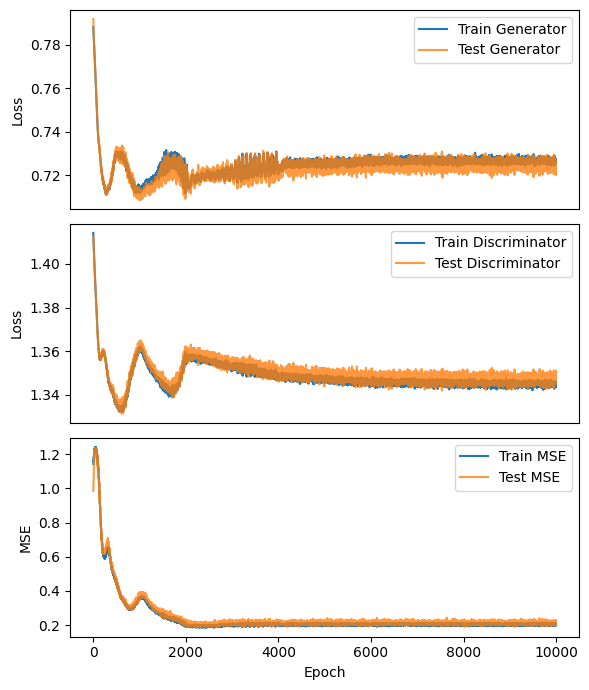

In [14]:
plt.figure(figsize=(6, 7))
plt.subplot(3,1,1)
plt.plot(losses_cgan_df['g_losses'], label='Train Generator')
plt.plot(losses_cgan_df['g_test_loss'], label='Test Generator', alpha = 0.8)
plt.ylabel('Loss')
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.subplot(3,1,2)
plt.plot(losses_cgan_df['d_losses'], label='Train Discriminator')
plt.plot(losses_cgan_df['d_test_loss'], label='Test Discriminator', alpha = 0.8)
plt.ylabel('Loss')
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.subplot(3,1,3)
plt.plot(losses_cgan_df['mse'], label='Train MSE')
plt.plot(losses_cgan_df['mse_test'], label='Test MSE', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('CGAN Losses.png', dpi=300, bbox_inches='tight')
plt.show()

## Training MDN Model

In [15]:
# Hyperparameters
input_dim = X_train.size(1)
hidden_dim = 32
num_mixture = 30
lr = 1e-4
epochs = 5000

In [16]:
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_mixture):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
        )

        self.num_mixture = num_mixture  #  π, σ, μ for each mixture
        self.out= nn.Linear(hidden_dim, num_mixture * 3)

    def forward(self, x):
        x = self.hidden(x)
        output = self.out(x)

        # Splitting output into mean, std and mixing coeffs
        pi_logist, mu, log_sigma = torch.chunk(output, 3, dim=1)
        sigma = torch.exp(log_sigma)    # ensure positivity
        pi = torch.nn.functional.softmax(pi_logist, dim=1)

        return pi, mu, sigma

##### MDN Loss function

In [17]:
def mdn_loss(pi, mu, sigma, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_probs = m.log_prob(y)
    weighted_log_probs = log_probs + torch.log(pi + 1e-8)
    log_sum = torch.logsumexp(weighted_log_probs, dim=1)
    loss = -log_sum.mean()
    return loss

In [18]:
model = MDN(input_dim, hidden_dim, num_mixture).to(device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

##### Training loop

In [19]:
# losses
train_loss = []
test_loss = []
mse_train = []
mse_test = []

In [20]:
for epoch in range(epochs):
    model.train()
    X_train, y_train = X_train.to(device), y_train.to(device)
    pi, mu, sigma = model(X_train)
    loss = mdn_loss(pi, mu, sigma, y_train)
    optim.zero_grad()
    loss.backward()
    optim.step()

    y_train_pred = (pi * mu).sum(dim=1, keepdim=True)
    mse_loss = criterion(y_train_pred, y_train)

    train_loss.append(loss.item())
    mse_train.append(mse_loss.item())

    # loss for test dataset
    model.eval()
    X_test, y_test = X_test.to(device), y_test.to(device)
    with torch.no_grad():
        pi, mu, sigma = model(X_test)
        loss = mdn_loss(pi, mu, sigma, y_test)

        y_test_pred = (pi * mu).sum(dim=1, keepdim=True)
        mse_loss = criterion(y_test_pred, y_test)

    test_loss.append(loss.item())
    mse_test.append(mse_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch : {epoch+1}/{epochs}, loss = {loss.item():4f}")


losses_mdn_df = pd.DataFrame(
    {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "mse_train": mse_train,
        "mse_test": mse_test,
    }
)

torch.save(model.state_dict(), "MDN_model.pth")
losses_mdn_df.to_csv("MDN_losses.csv", index=False)

Epoch : 500/5000, loss = 0.117274
Epoch : 1000/5000, loss = -0.305402
Epoch : 1500/5000, loss = -0.403955
Epoch : 2000/5000, loss = -0.463486
Epoch : 2500/5000, loss = -0.505121
Epoch : 3000/5000, loss = -0.532710
Epoch : 3500/5000, loss = -0.549013
Epoch : 4000/5000, loss = -0.560899
Epoch : 4500/5000, loss = -0.570501
Epoch : 5000/5000, loss = -0.573969


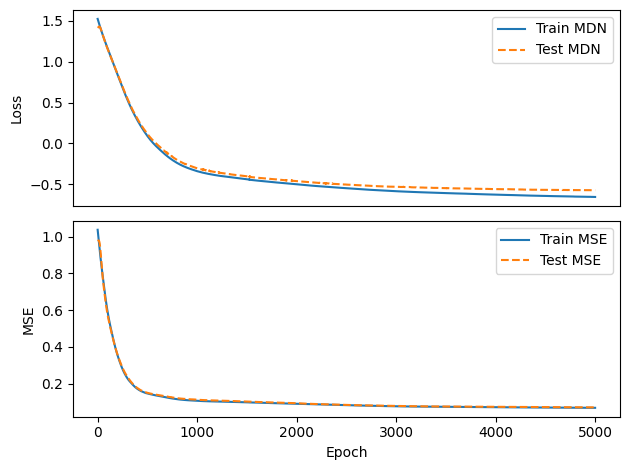

In [21]:
plt.subplot(2,1,1)
plt.plot(losses_mdn_df['train_loss'], label='Train MDN')
plt.plot(losses_mdn_df['test_loss'], label='Test MDN', linestyle = '--')
plt.ylabel('Loss')
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.subplot(2,1,2)
plt.plot(losses_mdn_df['mse_train'], label='Train MSE')
plt.plot(losses_mdn_df['mse_test'], label='Test MSE', linestyle = '--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('MDN Losses.png', dpi=300, bbox_inches='tight')
plt.show()